# Optimization

In [6]:
from sim_wecpen import *


all_vars = ['x_wec','x_type_wec','x_pen', 'x_disc_pen', 'p_pen','x_env','p_wec','p_fish_salmon', 'x_es', 'p_es', 'pos_env', 'p_vessel', 'p_diesel']

# with wave real data
all_vars = all_vars  + ['p_wave_vec']
# with wave average data
#all_vars = all_vars  + ['x_wave_ave']

args = {}
#args['fixed_num_pen'] = 11  # 11 without cost of travel from shore
#args['fixed_num_pen'] = 20  # 20 with cost of travel from shore

x_init, p_init, x, res_best, p_best, op_obj = wecpen_opt(all_vars, args)

init_result(x_init.nom0, x_init.name, p_init.nom_dict)
optimize_result(x.name, x.list, x.unit, res_best, p_best)

Initial objective function terms:
   cost_per_yield    210.130 [$/kg]
   price          2525048.957 [$]
   fish_yield      12016.592 [kg]
----------------------------------------
Initial WEC rated power:
   P_rated        1286.145 [kW]
----------------------------------------
Initial Port to deployment location distance:
   distance         284.652 [km]
----------------------------------------
Initial price break down:
   wec price            1362054.996 [$]
   pen price             70685.835 [$]
   fish feed price       24061.458 [$]
   energy st price      813000.000 [$]
   vessel travel price  255246.669 [$]
----------------------------------------
Initial constraints:
   P_gen_cons             3000.000 [kWh]
   fish_yield_cons        1407.353 [kg]
   env_Umin_cons             0.190 [m/s]
   env_Umax_cons             1.800 [m/s]
   env_tempmin_cons         14.000 [C]
   env_tempmax_cons         12.000 [C]
   env_salinitymin_cons      3.000 [PSU]
   env_salinitymax_cons      2.000 [P

# Plot power

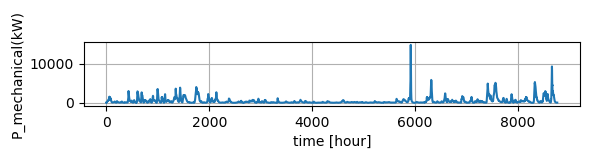

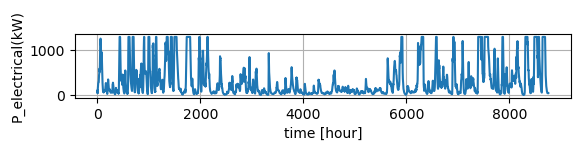

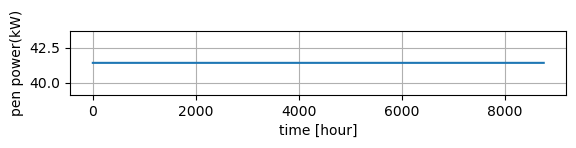

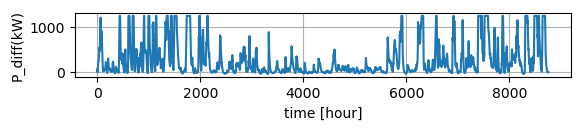

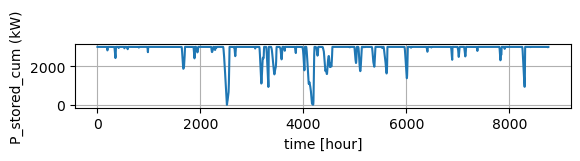

In [7]:
aqua_opt_obj = Aqua_Obj(res_best.x, x.name, p_best) 
aqua_opt_obj.plot_power()

# Plot fish growth and fish oxygen demand

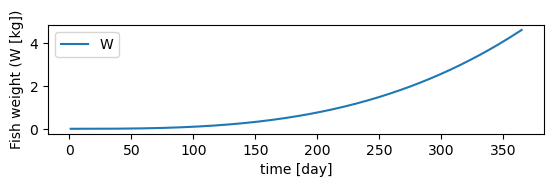

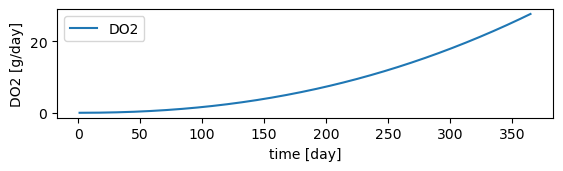

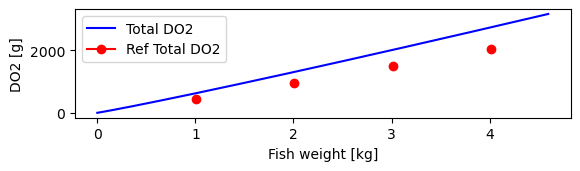

DO2 for 1kg fish 592.658417961274
DO2 for 2kg fish 1267.6196206239329
DO2 for 3kg fish 1968.158657940374
DO2 for 4kg fish 2690.091351663788
fish weight after 365 days 4597.867265255341


In [8]:
aqua_opt_obj.plot_variable()

# Plot objective function and constraints

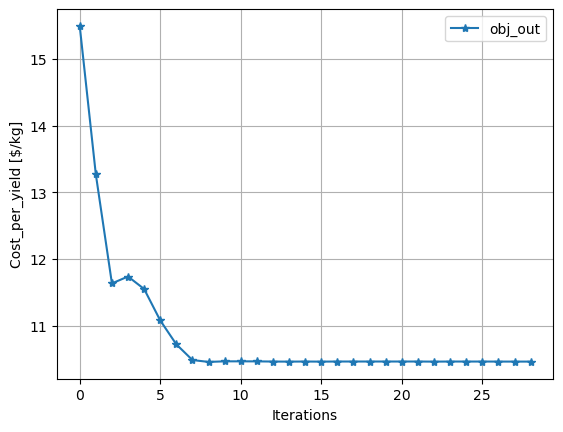

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(op_obj.f, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)
plt.show()

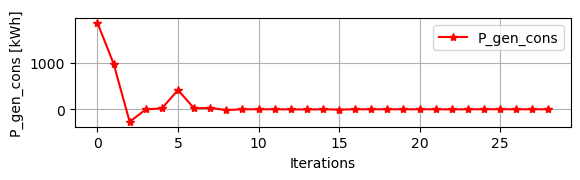

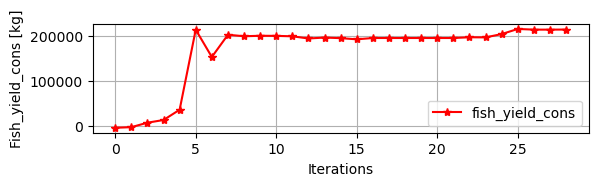

In [10]:
ax1 = plt.subplot(3,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', label='P_gen_cons', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax1.legend()
ax1.grid(True)
plt.show()

ax2 = plt.subplot(3,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', label='fish_yield_cons', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax2.legend()
ax2.grid(True)
plt.show()
